In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

%load_ext autoreload
%autoreload 2

In [8]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-September/Logs-ExponentialToLinear'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

Robomaker logs not available


In [9]:
df['track_width'] = 1.0688
df_dict = df.to_dict(orient='records')
df.rename(columns={'reward': 'old_reward'}, inplace=True)
df['reward'] = 0.0
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,old_reward,done,...,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,track_width,reward
0,0,1.0,-7.164549,0.861921,-94.949632,-21.951434,0.767830,-1,0.000000,False,...,0,43.312331,35.012,prepare,0.0,0,0,0,1.0688,0.0
1,0,2.0,-7.164573,0.861989,-94.958996,24.136118,0.500000,-1,0.000000,False,...,0,43.312331,35.052,in_progress,0.0,0,0,0,1.0688,0.0
2,0,3.0,-7.165043,0.858579,-95.010014,-30.000000,1.000000,-1,0.008157,False,...,0,43.312331,35.099,in_progress,0.0,0,0,0,1.0688,0.0
3,0,4.0,-7.167848,0.836914,-95.277972,-2.039417,0.821190,-1,0.060010,False,...,1,43.312331,35.167,in_progress,0.0,0,0,0,1.0688,0.0
4,0,5.0,-7.172621,0.796759,-95.538060,-6.208304,0.556646,-1,0.128947,False,...,1,43.312331,35.219,in_progress,0.0,0,0,0,1.0688,0.0


In [169]:
from test_reward_function import reward_function

for i in range(len(df['steps'])):
    if df.at[i, 'episode_status'] != 'prepare' or df.at[i, 'steps'] > 1.0:
        df.at[i, 'reward'] = reward_function(df_dict[i])

new reward not found, using reward as its values
Number of episodes =  839
Number of iterations =  41


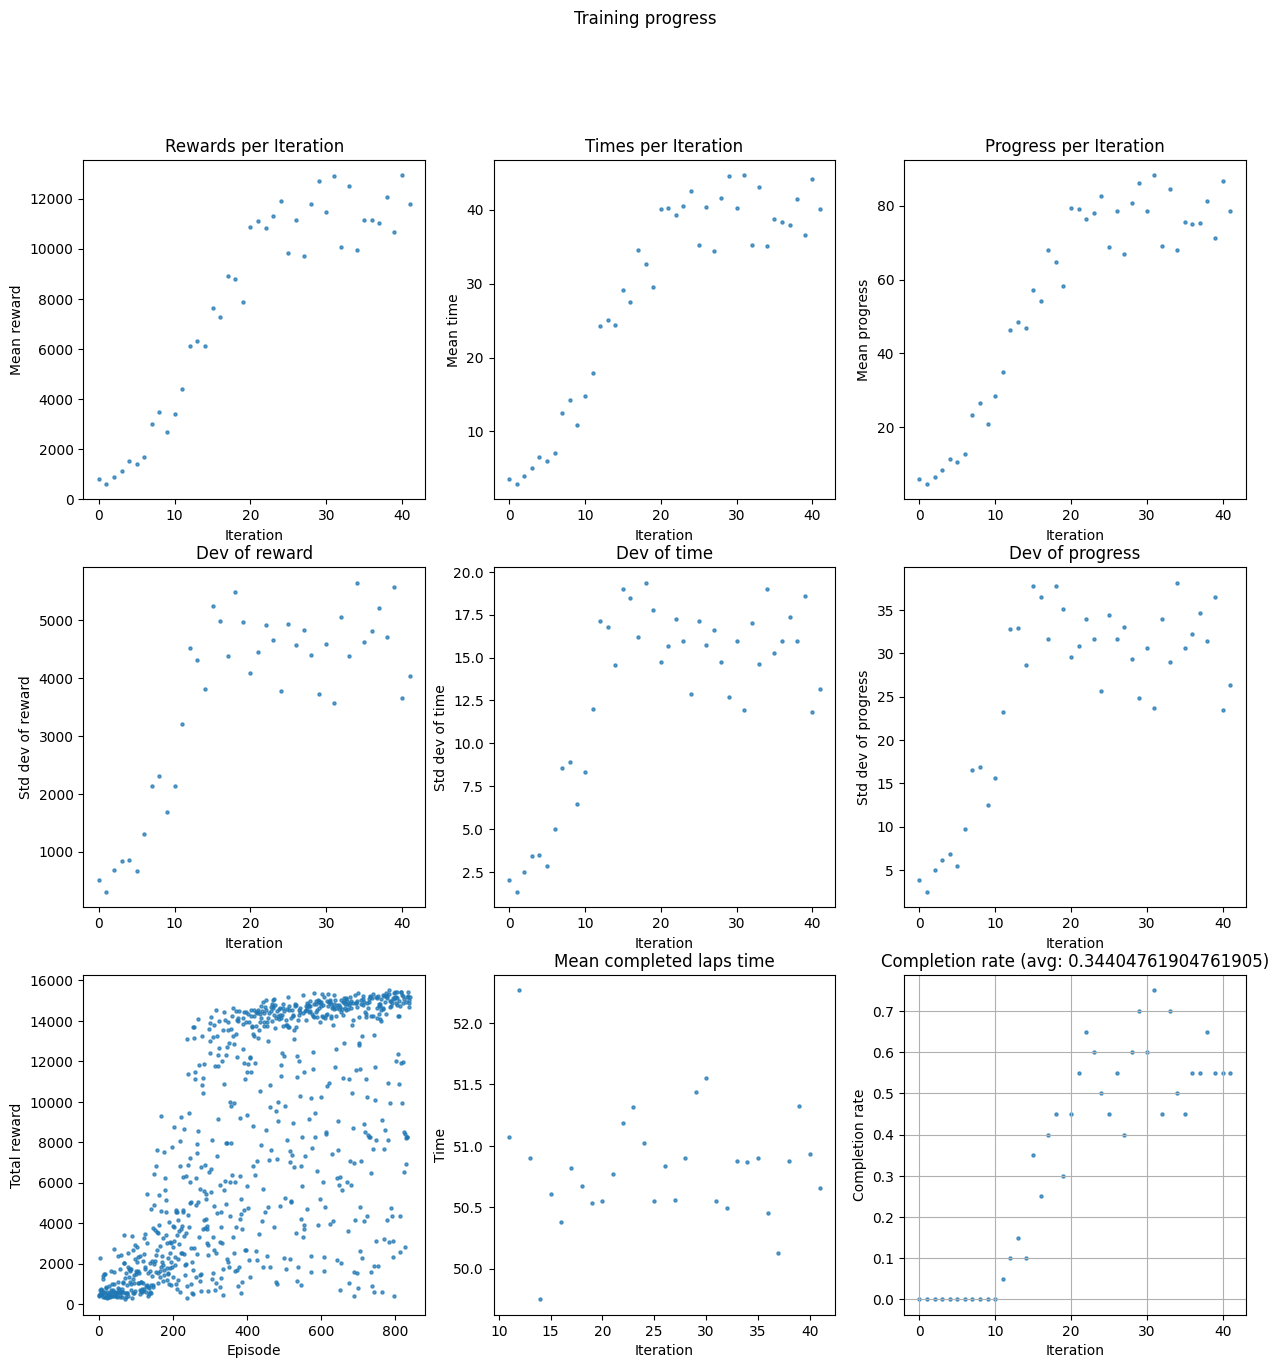

<Figure size 640x480 with 0 Axes>

In [170]:
if 'new_reward' in df.columns:
    df.drop(columns=['new_reward'], inplace=True)

simulation_agg = au.simulation_agg(df)

au.analyze_training_progress(simulation_agg, title='Training progress')

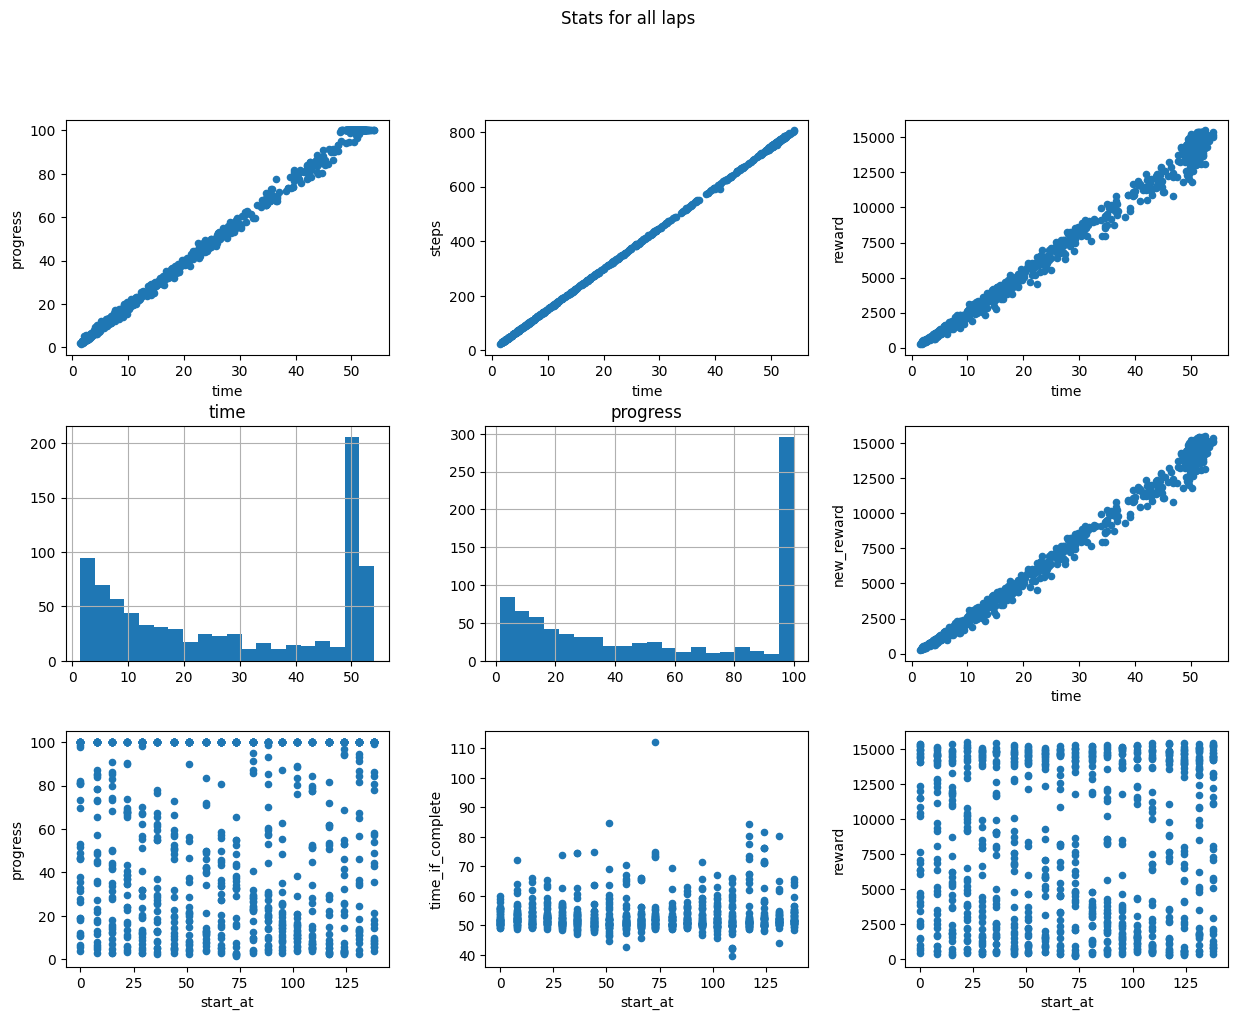

<Figure size 640x480 with 0 Axes>

In [171]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

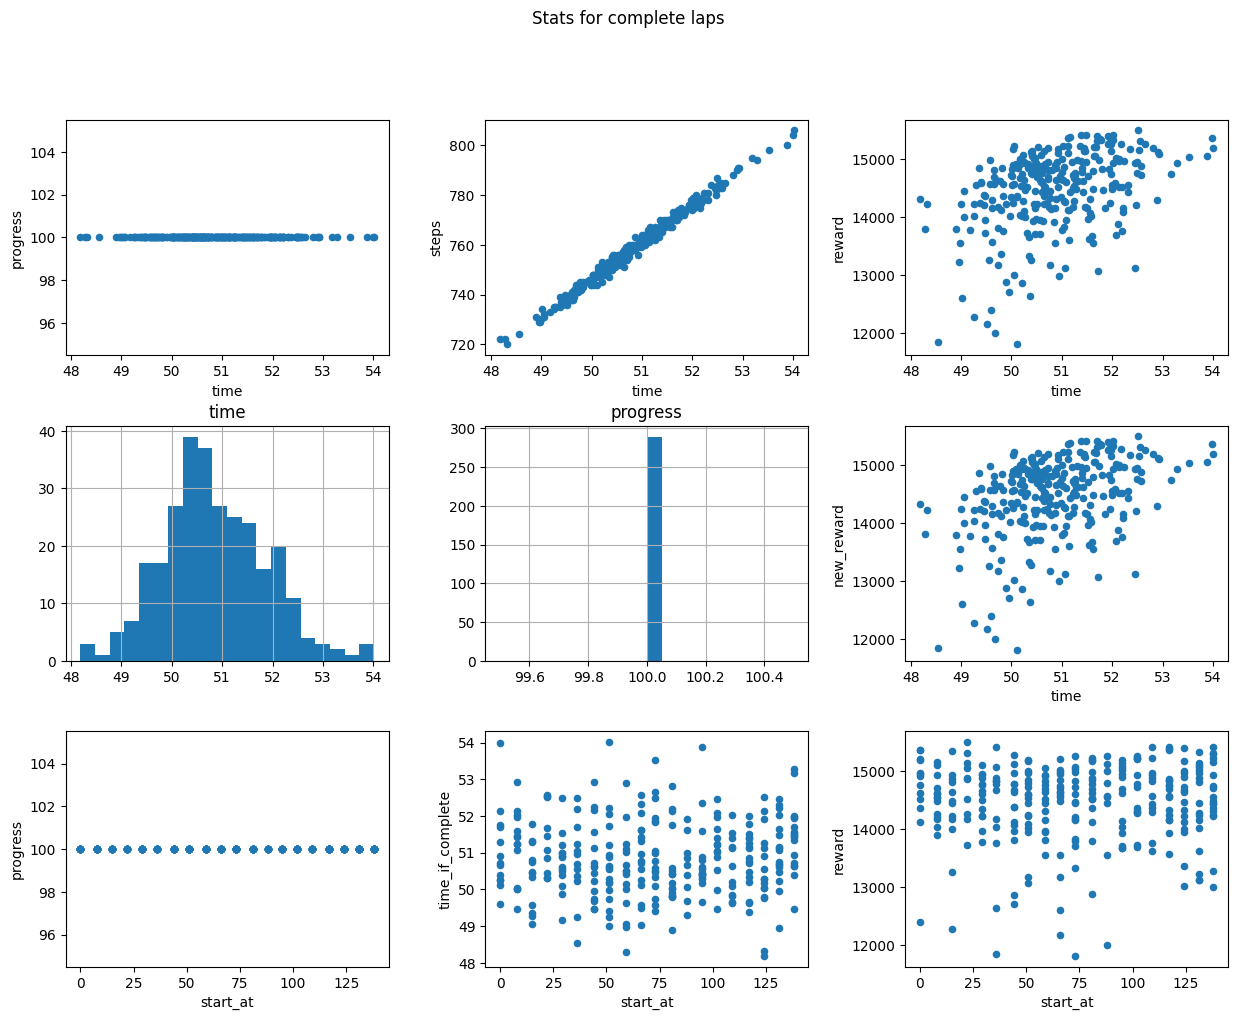

<Figure size 640x480 with 0 Axes>

In [172]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

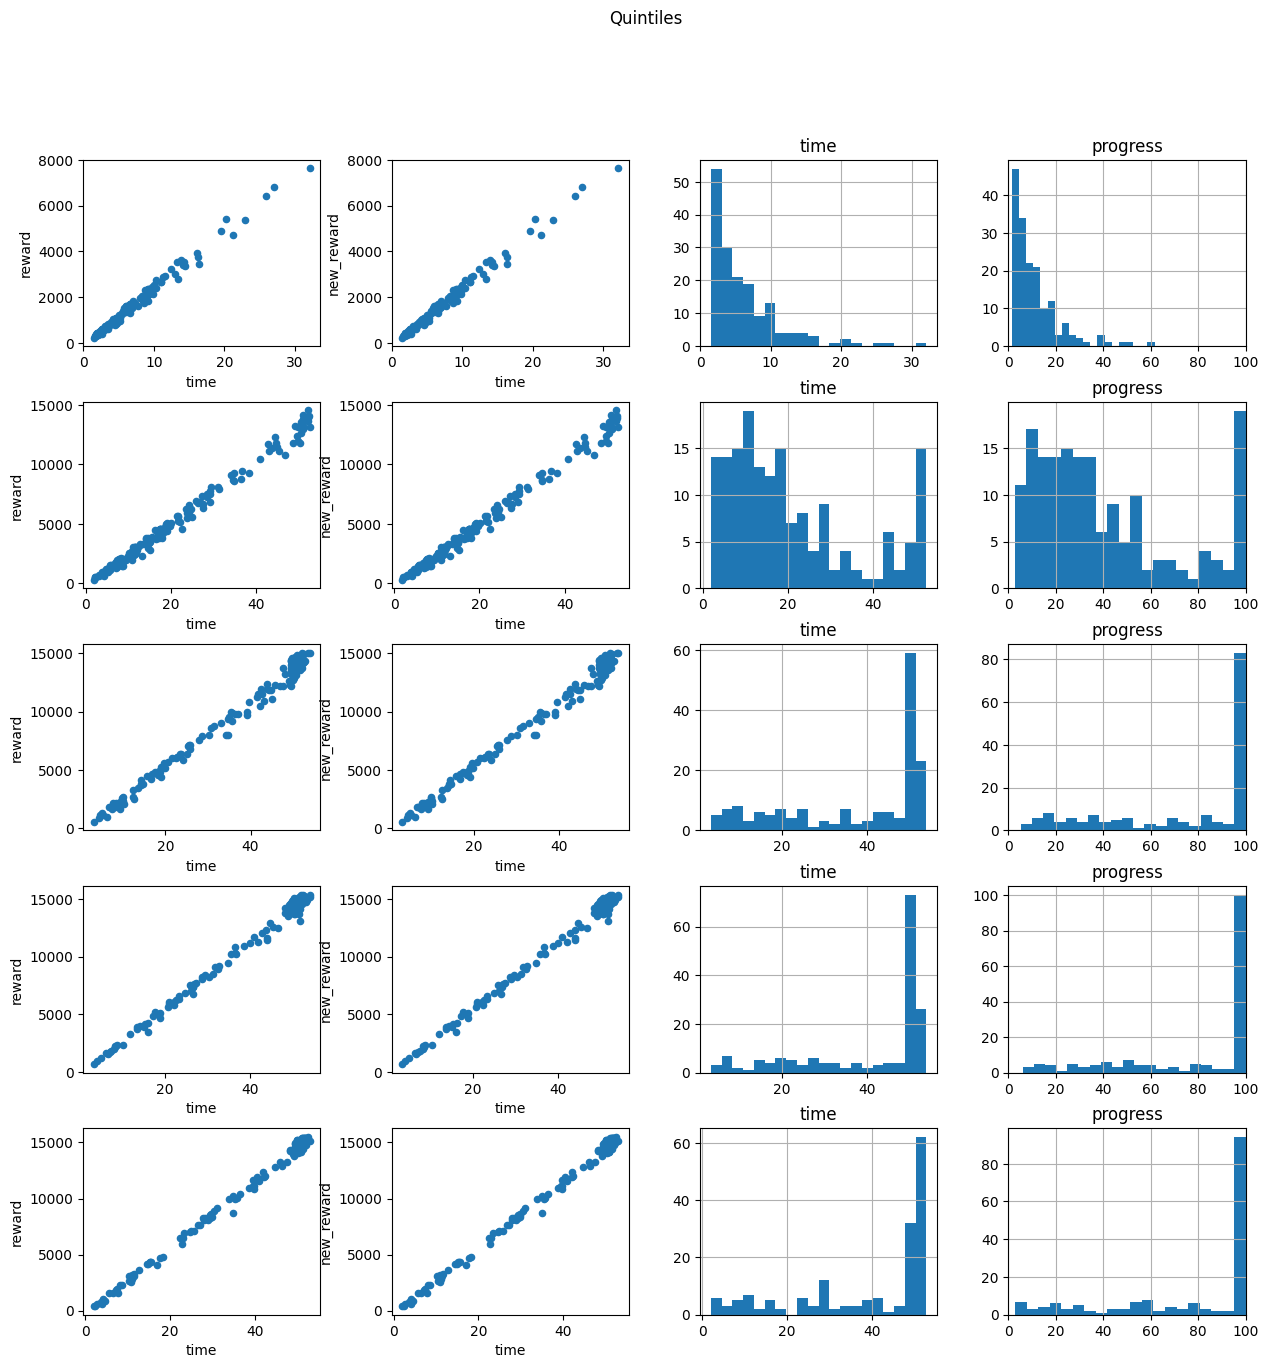

<Figure size 640x480 with 0 Axes>

In [173]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

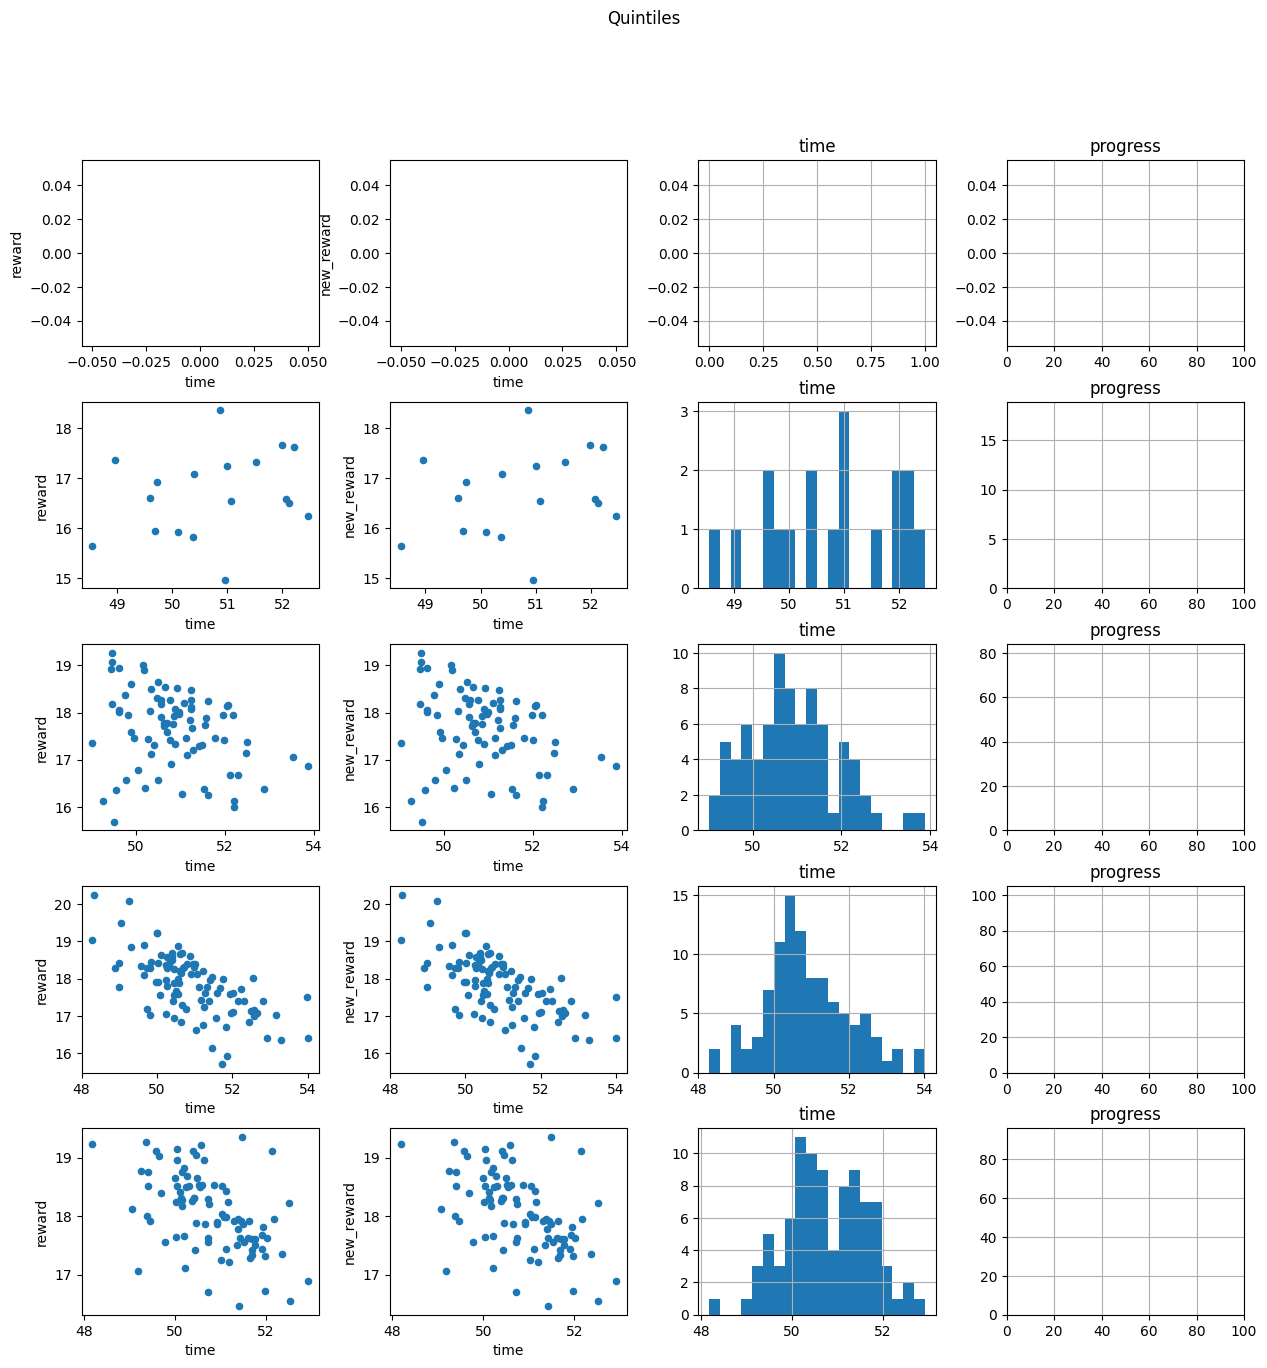

<Figure size 640x480 with 0 Axes>

In [67]:
au.scatter_by_groups(complete_ones, title='Quintiles')

In [68]:
complete_ones.sort_values('time')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
757,37,757,722.0,124,100.0,48.184,40.358829,19.235435,0.775240,19.235435,48.184,19.235435,5th,1
508,25,508,722.0,59,100.0,48.285,40.525519,19.024824,0.762708,19.024824,48.285,19.024824,4th,1
577,28,577,720.0,124,100.0,48.325,40.764579,20.254332,0.773166,20.254332,48.325,20.254332,4th,1
285,14,285,724.0,36,100.0,48.551,40.851230,15.650403,0.769742,15.650403,48.551,15.650403,2nd,1
631,31,631,731.0,81,100.0,48.899,40.945509,18.295217,0.764381,18.295217,48.899,18.295217,4th,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,29,599,794.0,138,100.0,53.286,43.084200,16.342439,0.737110,16.342439,53.286,16.342439,4th,1
450,22,450,798.0,73,100.0,53.528,43.079958,17.050003,0.744907,17.050003,53.528,17.050003,3rd,1
473,23,473,800.0,95,100.0,53.875,43.118910,16.855298,0.739954,16.855298,53.875,16.855298,3rd,1
580,29,580,804.0,0,100.0,53.989,43.203226,17.507826,0.739624,17.507826,53.989,17.507826,4th,1


In [69]:
tu = TrackIO(base_path="/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks")

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_august_open.npy - I don't know
2022_july_open.npy - I don't know
2022_june_open.npy - I don't know
2022_september_open.npy - I don't know
AWS_track.npy - I don't know
Bowtie_track.npy - Bowtie Track
Canada_Training.npy - Toronto Turnpike Training
China_track.npy - Shanghai Sudu Training
H_track.npy - H track
London_Loop_Train.npy - I don't know
Mexico_track.npy - Cumulo Carrera Training
New_York_Track.npy - Empire City Training
Oval_track.npy - Oval Track
Straight_track.npy - Straight track
Tokyo_Training_track.npy - Kumo Torakku Training
Virtual_May19_Train_track.npy - London Loop Training
canada_race.npy - I don't know
reInvent2019_track.npy - The 2019 DeepRacer Championship Cup
reinvent_base.npy - re:Invent 2018


Loaded 146 waypoints


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


<AxesSubplot:>

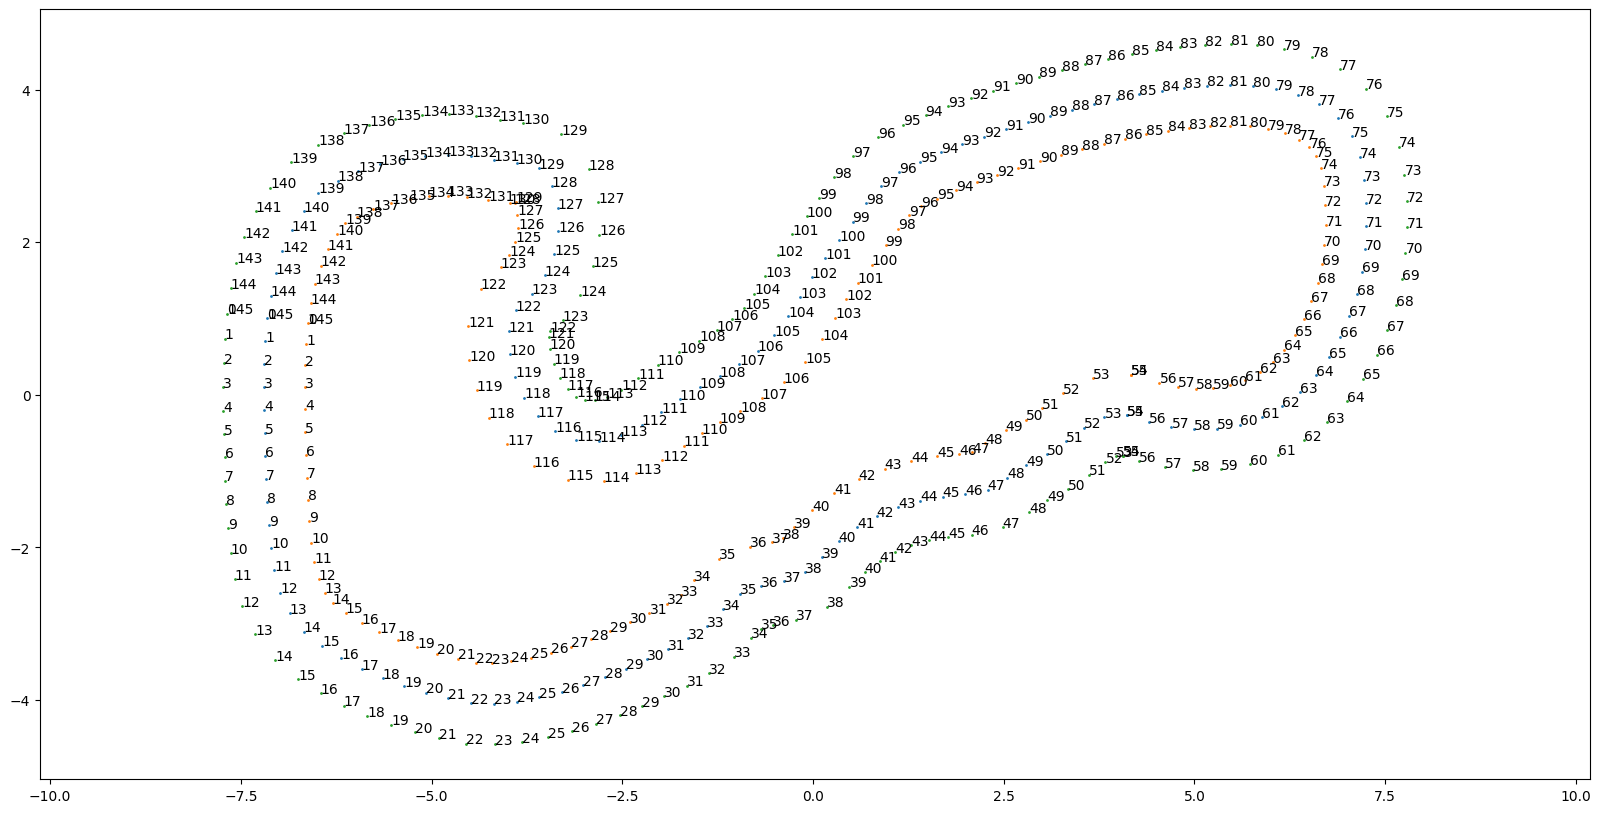

In [70]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "2022_august_open"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

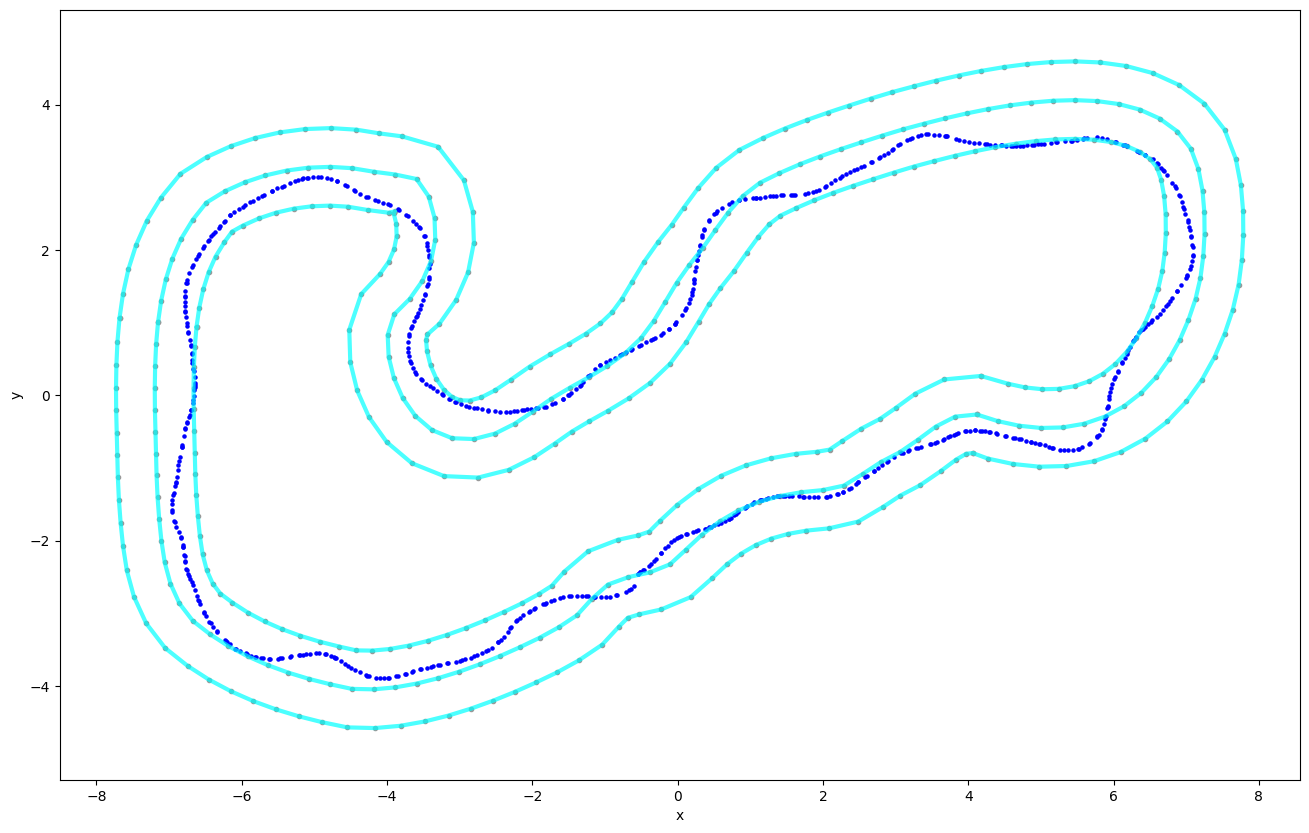

<Figure size 640x480 with 0 Axes>

In [71]:
episode_id = 285

pu.plot_selected_laps([episode_id], df, track)

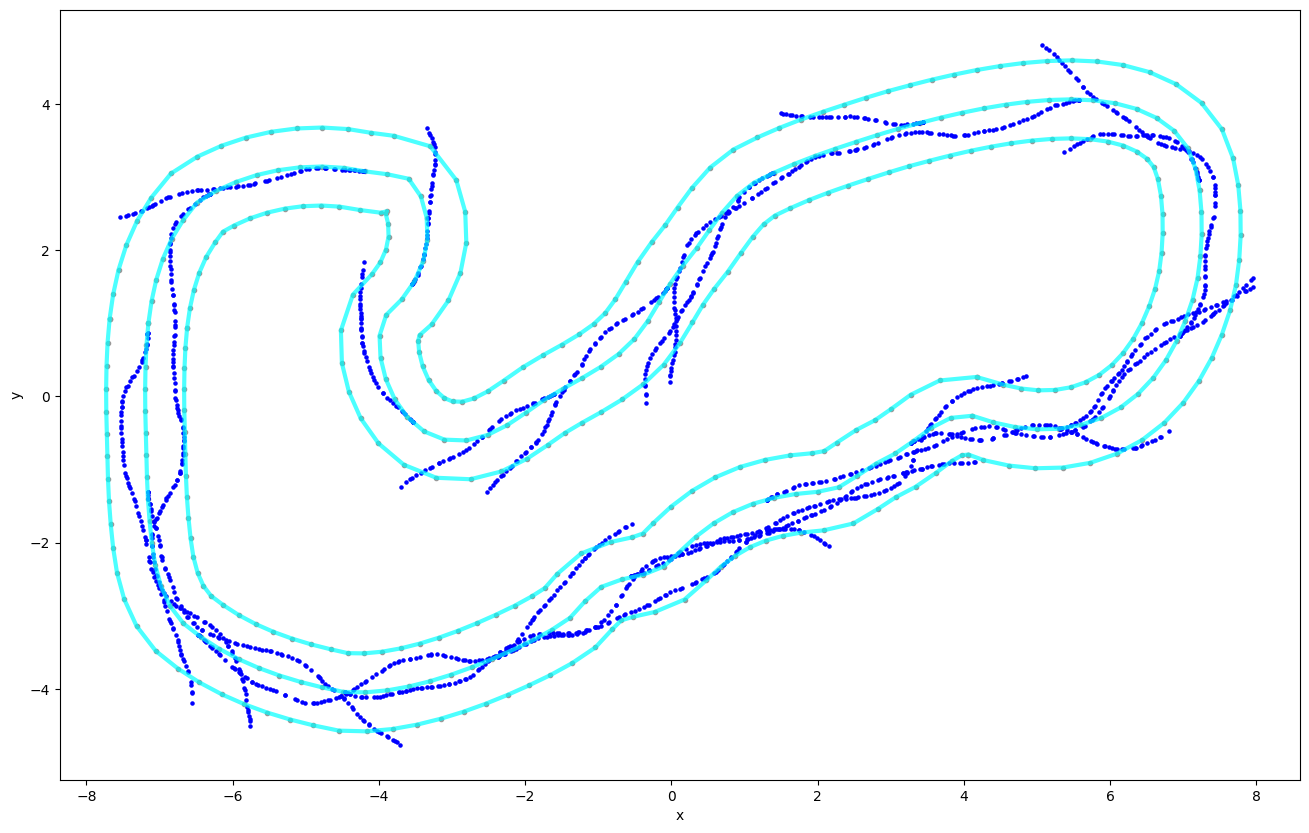

<Figure size 640x480 with 0 Axes>

In [25]:
iteration_id = 5

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

In [41]:
print(df['reward'].max())
print(df['reward'].mean())
print(df['reward'].min())

1.1829656264668778
0.22622542593775694
0.0


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


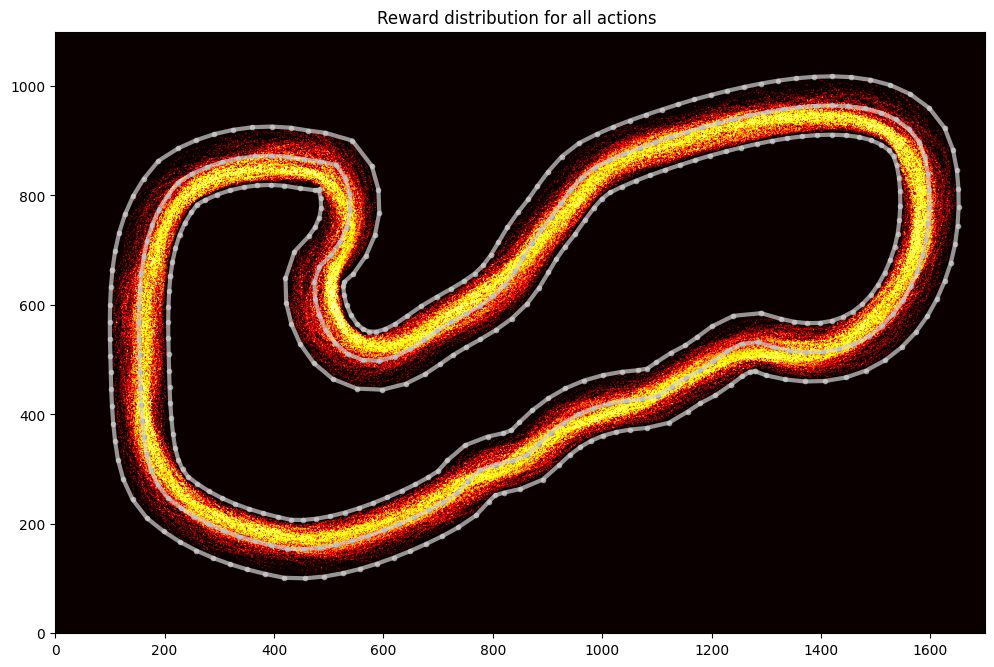

<Figure size 640x480 with 0 Axes>

In [176]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

# pu.plot_track(df[df['progress'] == 100], track)
pu.plot_track(df, track)

In [43]:
print(df[df['progress'] == 100]['reward'].max())
print(df[df['progress'] == 100]['reward'].mean())
print(df[df['progress'] == 100]['reward'].min())

0.8208966609496363
0.31234527286843455
0.0


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


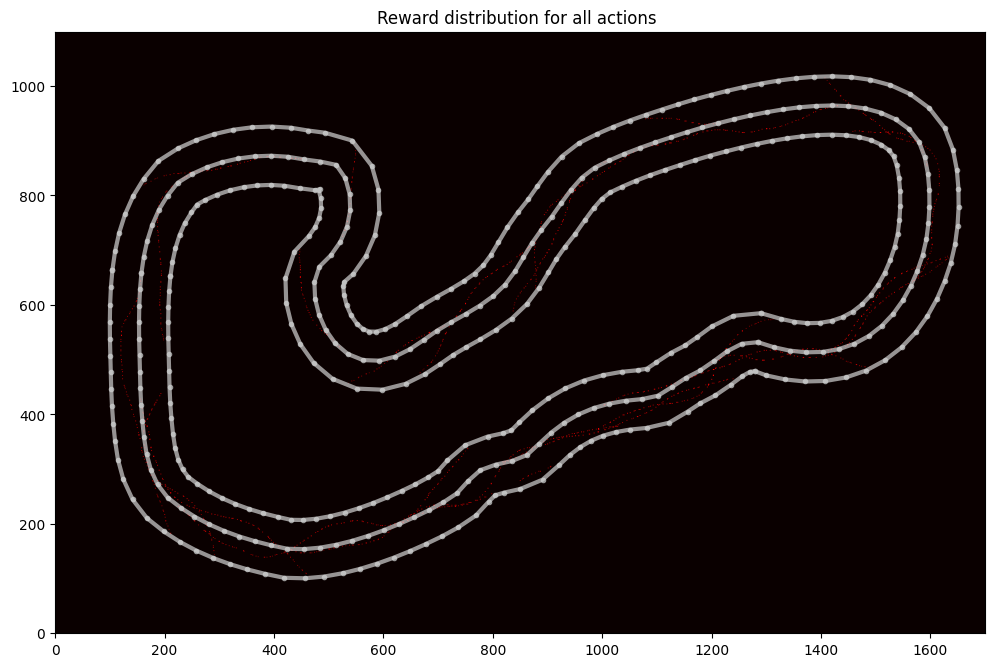

<Figure size 640x480 with 0 Axes>

In [174]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 5

pu.plot_track(df[df['iteration'] == iteration_id], track)

In [25]:
track_path = "/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks/"

def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_august_open"
waypoints = get_track_waypoints(trackname)

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [26]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
    #   plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    #fig = plt.figure(1, figsize=(12, 16))
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

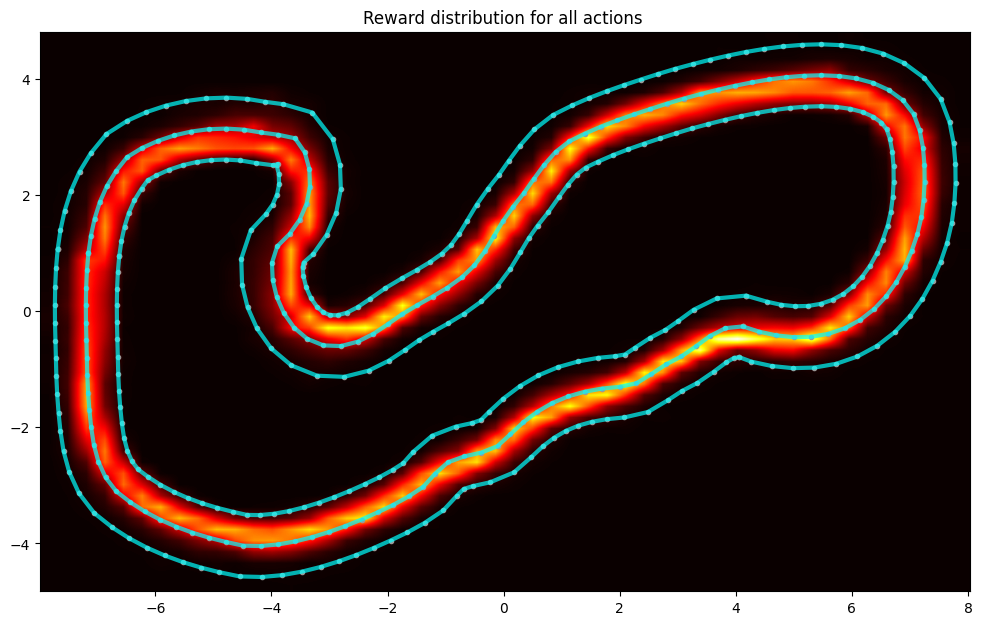

In [27]:
iteration_id = 41
track_img,extent = plot_track(df, track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track_img, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

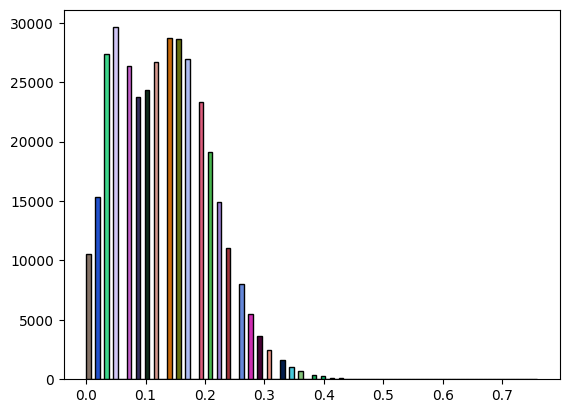

['#847266', '#35F5DF', '#2252CE', '#5C8934', '#3FD68C', '#7CE3B7', '#D0C6F6', '#1B9BA3', '#A19D58', '#C561CB', '#B10D5B', '#372F61', '#18BF07', '#102E1B', '#58899C', '#D5988E', '#E90191', '#CD2258', '#C96A09', '#4CD14F', '#656F0D', '#0B8B3B', '#ACBBF2', '#4DE08C', '#4F3365', '#DC5D7C', '#1850C2', '#47B64E', '#CED530', '#987DD1', '#C1CCF2', '#A1343C', '#EF5523', '#034A4D', '#6587D8', '#3074BB', '#CE2EB1', '#A9B74D', '#460133', '#B46400', '#EC9384', '#6CF364', '#13F5EE', '#021B4A', '#A7CA58', '#47C8DA', '#22E7F8', '#84C37A', '#DA912D', '#B5A12E', '#1FB45F', '#A770BE', '#09C873', '#80191B', '#1ECD2A', '#80D684', '#D23BF6', '#6ADA1F', '#45DC8B', '#10133A', '#C7E6FA', '#E84EE7', '#4EC660', '#42C874', '#815FD4', '#1A1209', '#1FA700', '#981E78', '#2FC949', '#2DF847', '#69CEE1', '#2C3D8D', '#E4239D', '#2A1E57', '#1140F2', '#D79C71', '#0D668A', '#41C62C', '#A4A0C0', '#A5D6F8', '#A6C4B2', '#1BA894', '#AB5950', '#F2C918', '#56EDE3', '#094D91', '#C9AC58', '#8228D7', '#F01551', '#A97147', '#6899E6'

In [46]:
import random
import string

# Figure and set of subplots
fig, ax = plt.subplots()

# Plot a histogram with random data
N, bins, patches = ax.hist(df['reward'], bins=100, edgecolor='black', linewidth=1)

# Random facecolor for each bar
colors = []
for i in range(len(N)):
    colors.append("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))
    patches[i].set_facecolor(colors[i])

# Display the plot
plt.show()
print(colors)
print(bins)

In [47]:
print(df['reward'].max())
print(df['reward'].min())

0.7586206896551724
0.0


In [71]:
df.columns

Index(['episode', 'steps', 'x', 'y', 'heading', 'steering_angle', 'speed',
       'action', 'old_reward', 'done', 'all_wheels_on_track', 'progress',
       'closest_waypoint', 'track_len', 'tstamp', 'episode_status',
       'pause_duration', 'iteration', 'worker', 'unique_episode',
       'track_width', 'reward', 'new_reward'],
      dtype='object')